<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/tutorials/W3D2_DynamicNetworks/W3D2_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy: Week 3, Day 2, Tutorial 1

# Neuronal Network Dynamics: Neural Rate Models



## Background

The brain is a complex system, not because it is composed of a large number of diverse types of neurons, but mainly because of how neurons are connected to each other. The brain is a very large network of densely interconnected neurons. 

The activity of neurons is constantly evolving in time. For this reason, neurons can be modeled as dynamical systems. The dynamical system approach is only one of the many modeling approaches that computational neuroscientists have developed (other points of views include information processing, network science, and statistical models). How the dynamics of neuronal networks affect the representation and processing of information in the brain is an open question. However, signatures of altered brain dynamics present in many brain diseases (e.g., in epilepsy or Parkinson's disease) tell us that it is crucial to study neuronal dynamics if we want to understand the brain.

In this tutorial, we will simulate and study one of the simplest models of biological neuronal networks. Instead of modeling and simulating individual excitatory neurons (e.g., LIF models that you implemented yesterday), we will treat them as a single homogeneous population and approximate their dynamics using a single one-dimensional equation describing the evolution of their average spiking rate in time.

## Objectives
In this tutorial we will learn how to build a firing rate model of a single population of excitatory neurons. 

Steps:
- Write the equation for the firing rate dynamics of a 1D excitatory population.
- Visualize the response of the population as a function of parameters such as threshold level and gain, using the frequency-current (F-I) curve.
- Numerically simulate the dynamics of the excitatory population and find the fixed points of the system. 
- Investigate the stability of the fixed points by linearizing the dynamics around them.
 


# Setup

In [1]:
# Imports
import matplotlib.pyplot as plt    # import matplotlib
import numpy as np                 # import numpy
import scipy.optimize as opt       # import root-finding algorithm
import ipywidgets as widgets       # interactive display

In [2]:
#@title Figure Settings
%matplotlib inline

fig_w, fig_h = 6, 4
my_fontsize = 16
my_params = {'axes.labelsize': my_fontsize,
          'axes.titlesize': my_fontsize,
          'figure.figsize': [fig_w, fig_h],
          'font.size': my_fontsize,
          'legend.fontsize': my_fontsize-4,
          'lines.markersize': 8.,
          'lines.linewidth': 2.,
          'xtick.labelsize': my_fontsize-2,
          'ytick.labelsize': my_fontsize-2}

plt.rcParams.update(my_params)

In [3]:
# @title Helper functions

def plot_fI(x, f):
  plt.figure(figsize=(6,4)) # plot the figure
  plt.plot(x, f, 'k')
  plt.xlabel('x (a.u.)', fontsize=14.)
  plt.ylabel('F(x)', fontsize=14.)
  plt.show()

In [4]:
#@title Helper functions
def plot_dE_E(E, dEdt):
  plt.figure()
  plt.plot(E_grid, dEdt, 'k')
  plt.plot(E_grid, 0.*E_grid, 'k--')
  plt.xlabel('E activity')
  plt.ylabel(r'$\frac{dE}{dt}$', fontsize=20)
  plt.ylim(-0.1, 0.1)

def plot_dFdt(x,dFdt):
  plt.figure()
  plt.plot(x, dFdt, 'r')
  plt.xlabel('x (a.u.)', fontsize=14.)
  plt.ylabel('dF(x)', fontsize=14.)
  plt.show()


# Neuronal network dynamics

Video available at https://youtube.com/watch?v=ZSsAaeaG9ZM


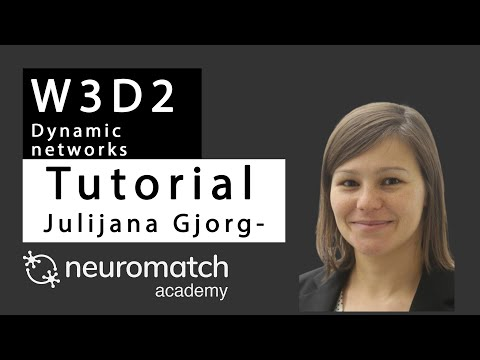

In [5]:
#@title Video: Dynamic networks
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="ZSsAaeaG9ZM", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

## Dynamics of a single excitatory population

Individual neurons respond by spiking. When we average the spikes of neurons in a population, we can define the average firing activity of the population. In this model, we are interested in how the population-averaged firing varies as a function of different network parameters.

\begin{align}
\tau_E \frac{dE}{dt} &= -E + F(w_{EE}E + I^{\text{ext}}_E)  \quad\qquad (1)
\end{align}

$E(t)$ represents the average firing rate of the excitatory population at time $t$, $\tau_E$ controls the timescale of the evolution of the average firing rate, $w_{EE}$ denotes the strength (synaptic weight) of the recurrent excitatory input to the population, $I^{\text{ext}}_E$ represents the external input, and the transfer function $F(\cdot)$ (which can be related to f-I curve of individual neurons described in the next sections) represents the population activation function in response to all received inputs.


To start building the model, please execute the cell below to initialize the simulation parameters.

In [6]:
#@title Default parameters for a single excitatory population model
def default_parsE( **kwargs):
  pars = {}
  
  ### Excitatory parameters ###
  pars['tau_E']   = 1.    # Timescale of the E population [ms]
  pars['a_E']     = 1.2   # Gain of the E population
  pars['theta_E'] = 2.8   # Threshold of the E population

  ### Connection strength ###
  pars['wEE'] = 0. # E to E, we first set it to 0

  ### External input ###
  pars['I_ext_E']  = 0.

  ### simulation parameters ###
  pars['T'] = 20. # Total duration of simulation [ms]
  pars['dt'] = .1  # Simulation time step [ms]
  pars['E_init'] = 0.2 # Initial value of E
  
  ### External parameters if any ###
  for k in kwargs:
      pars[k] = kwargs[k]
      
  pars['range_t'] = np.arange(0, pars['T'], pars['dt']) # Vector of discretized time points [ms]
        
  return pars

You can use:
- `pars = default_parsE()` to get all the parameters, and then you can execute `print(pars)` to check these parameters. 
- `pars = default_parsE(T=T_sim, dt=time_step)` to set new simulation time and time step
- After `pars = default_parsE()`, use `pars['New_para'] = value` to add an new parameter with its value

## F-I curves
In electrophysiology, a neuron is often characterized by its spike rate output in response to input currents. This is often called the **F-I** curve, denoting the spike frequency (**F**) in response to different injected currents (**I**). We estimated this for an LIF neuron in yesterday's tutorial.

The transfer function $F(\cdot)$ in Equation (1) represents the gain of the population as a function of the total input. The gain is often modeled as a sigmoidal function, i.e., more input drive leads to a nonlinear increase in the population firing rate. The output firing rate will eventually saturate for high input values. 

A sigmoidal $F(\cdot)$ is parameterized by its gain $a$ and threshold $\theta$.

$$ F(x;a,\theta) = \frac{1}{1+\text{e}^{-a(x-\theta)}} - \frac{1}{1+\text{e}^{a\theta}}  \quad(2)$$

The argument $x$ represents the input to the population. Note that the second term is chosen so that $F(0;a,\theta)=0$.

Many other transfer functions (generally monotonic) can be also used. Examples are the rectified linear function $ReLU(x)$ or the hyperbolic tangent $tanh(x)$.

### Exercise 1: Implement F-I curve 

Let's first investigate the activation functions before simulating the dynamics of the entire population. 

In this exercise, you will implement a sigmoidal **F-I** curve or transfer function $F(x)$, with gain $a$ and threshold level $\theta$ as parameters.

In [7]:
# Excercise 1
def F(x,a,theta): 
  """
  Population activation function.

  Args:
    x (float): the population input
    a (float): the gain of the function
    theta (float): the threshold of the function
    
  Returns:
    float: the population activation response F(x) for input x
  """

  #################################################################################
  ## TODO for students: compute f = F(x), remove the NotImplementedError once done# 
  #################################################################################
  # the exponential function: np.exp(.)
  # f = ...
  raise NotImplementedError("Student excercise: implement the f-I function")

  return f

# Uncomment these lines when you've filled the function, then run the cell again 
# to plot the f-I curve.
pars = default_parsE() # get default parameters 
# print(pars)          # print out pars to get familiar with parameters
x = np.arange(0,10,.1) # set the range of input

# Uncomment this when you fill the exercise, and call the function
# plot_fI(x,  F(x,pars['a_E'],pars['theta_E']))

findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


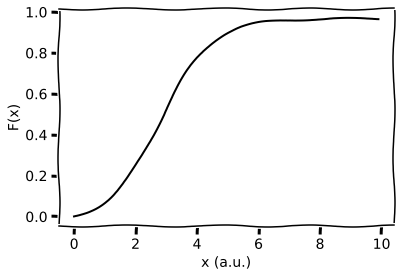

In [8]:
# to_remove solution
def F(x,a,theta): 
  """
  Population activation function.

  Args:
    x     : the population input
    a     : the gain of the function
    theta : the threshold of the function
  
  Returns:
    the population activation response F(x) for input x
  """

  # add the expression of f = F(x)
  f = (1+np.exp(-a*(x-theta)))**-1 - (1+np.exp(a*theta))**-1

  return f

pars = default_parsE() # get default parameters
x = np.arange(0,10,.1) # set the range of input

with plt.xkcd():
  plot_fI(x, F(x,pars['a_E'],pars['theta_E']))

### Interactive Demo: Parameter exploration of F-I curve
Here's an interactive demo that shows how the F-I curve is changing for different values of the gain and threshold parameters.


**Remember to enable the demo by running the cell.**

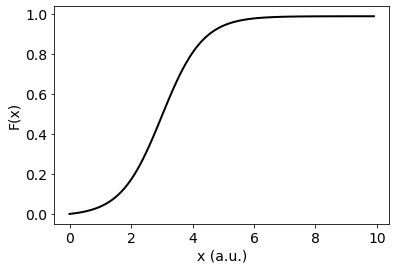

In [9]:
#@title F-I curve Explorer
def interactive_plot_FI(a, theta):
  '''
  Population activation function.

  Expecxts:
  a     : the gain of the function
  theta : the threshold of the function
  
  Returns:
  plot the F-I curve with give parameters
  '''
  # set the range of input
  x = np.arange(0,10,.1)
  plt.figure()
  plt.plot(x, F(x, a, theta), 'k')
  plt.xlabel('x (a.u.)', fontsize=14.)
  plt.ylabel('F(x)', fontsize=14.)
  plt.show()



_ = widgets.interact(interactive_plot_FI, a = (0.3, 3., 0.3), \
                                              theta = (2., 4., 0.2)) 

## Simulation scheme of E dynamics

Because $F(\cdot)$ is a nonlinear function, the exact solution of Equation $1$ can not be determined via analytical methods. Therefore, numerical methods must be used to find the solution. In practice, the derivative on the left-hand side of Equation (1) can be approximated using the Euler method on a time-grid of stepsize $\Delta t$:

\begin{align}
&\frac{dE}{dt} \approx \frac{E[k+1]-E[k]}{\Delta t} 
\end{align}
where $E[k] = E(k\Delta t)$. 

Thus,

$$\Delta E[k] = \frac{\Delta t}{\tau_E}[-E[k] + F(w_{EE}E[k] + I^{\text{ext}}_E(k;a_E,\theta_E)]$$


Hence, Equation (1) is updated at each time step by:

$$E[k+1] = E[k] + \Delta E[k]$$

**_Please execute the following cell to enable the WC simulator_**

In [10]:
#@title E population simulator: `simulate_E`
def simulate_E(pars):
    
  """
  Simulate an excitatory population of neurons 
  
  Args:
    pars : Parameter dictionary
  
  Returns:
    E    : Activity of excitatory population (array)
  """
  
  # Set parameters
  tau_E, a_E, theta_E = pars['tau_E'], pars['a_E'], pars['theta_E']
  wEE = pars['wEE']
  I_ext_E = pars['I_ext_E']
  E_init = pars['E_init']      
  dt, range_t = pars['dt'], pars['range_t'] 
  Lt = range_t.size 
      
  # Initialize activity
  E = np.zeros(Lt)
  E[0] = E_init
  I_ext_E = I_ext_E*np.ones(Lt)

  # Update the E activity 
  for k in range(Lt-1):
      dE = dt/tau_E * (-E[k] + F(wEE*E[k]+I_ext_E[k], a_E, theta_E))
      E[k+1] = E[k] + dE
      
  return E

print(help(simulate_E))


Help on function simulate_E in module __main__:

simulate_E(pars)
    Simulate an excitatory population of neurons 
    
    Args:
      pars : Parameter dictionary
    
    Returns:
      E    : Activity of excitatory population (array)

None


#### Interactive Demo: Parameter Exploration of single population dynamics

Note that $w_{EE}=0$, as in the default setting, means no recurrent input to the excitatory population in Equation (1). Hence, the dynamics is entirely determined by the external input $I_{E}^{\text{ext}}$. Try to explore how $E_{sim}(t)$ changes with different $I_{E}^{\text{ext}}$ and $\tau_E$ parameter values, and investigate the relationship between $F(I_{E}^{\text{ext}}; a_E, \theta_E)$ and the steady value of E. Note that, $E_{ana}(t)$ denotes the analytical solution.

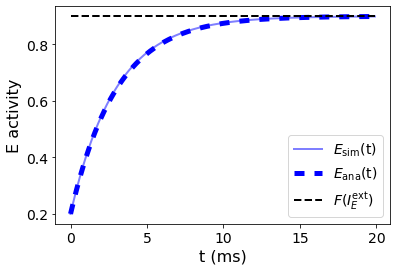

In [11]:
#@title Mean-field model Explorer

# get default parameters
pars = default_parsE(T=20.)

def Myplot_E_diffI_difftau(I_ext, tau_E):
  # set external input and time constant
  pars['I_ext_E'] = I_ext
  pars['tau_E'] = tau_E

  # simulation
  E = simulate_E(pars)
  
  # Analytical Solution
  E_ana = pars['E_init'] + (F(I_ext,pars['a_E'],pars['theta_E'])-pars['E_init'])*\
  (1.-np.exp(-pars['range_t']/pars['tau_E']))

  # plot
  plt.figure()
  plt.plot(pars['range_t'], E, 'b', label=r'$E_{\mathrm{sim}}$(t)', alpha=0.5, zorder=1)
  plt.plot(pars['range_t'], E_ana, 'b--', lw=5, dashes=(2,2),\
            label=r'$E_{\mathrm{ana}}$(t)', zorder=2)
  plt.plot(pars['range_t'], F(I_ext,pars['a_E'],pars['theta_E'])\
          *np.ones(pars['range_t'].size), 'k--', label=r'$F(I_E^{\mathrm{ext}})$')
  plt.xlabel('t (ms)', fontsize=16.)
  plt.ylabel('E activity', fontsize=16.)
  plt.legend(loc='best', fontsize=14.)
  plt.show()

_ = widgets.interact(Myplot_E_diffI_difftau, I_ext = (0.0, 10., 1.),\
                                             tau_E = (1., 5., 0.2)) 


### Think!
Above, we have numerically solved a system driven by a positive input and that, if $w_{EE} \neq 0$, receives an excitatory recurrent input (**try changing the value of $w_{EE}$ to a positive number**). Yet, $E(t)$ either decays to zero or reaches a fixed non-zero value.
- Why doesn't the solution of the system "explode" in a finite time? In other words, what guarantees that E(t) stays finite? 
- Which parameter would you change in order to increase the maximum value of the response? 

## Fixed points of the E system


Video available at https://youtube.com/watch?v=B31fX6V0PZ4


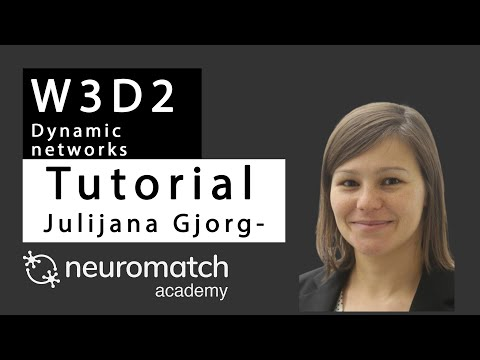

In [12]:
#@title Video: Fixed point
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="B31fX6V0PZ4", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

As you varied the two parameters in the last Interactive Demo, you noticed that, while at first the system output quickly changes, with time, it reaches its maximum/minimum value and does not change anymore. The value eventually reached by the system is called the **steady state** of the system, or the **fixed point**. Essentially, in the steady states the derivative with respect to time of the activity ($E$) is zero, i.e. $\frac{dE}{dt}=0$. 

We can find that the steady state of the Equation $1$ by setting $\displaystyle{\frac{dE}{dt}=0}$ and solve for $E$:

$$E_{\text{steady}} = F(w_{EE}E_{\text{steady}} + I^{\text{ext}}_E;a_E,\theta_E) = 0, \qquad (3)$$

When it exists, the solution of Equation $3$ defines a **fixed point** of the dynamics which satisfies $\displaystyle{\frac{dE}{dt}=0}$ (and determines steady state of the system). Notice that the right-hand side of the last equation depends itself on $E_{steady}$. If $F(x)$ is nonlinear it is not always possible to find an analytical solution that can instead be found via numerical simulations, as we will do later.

From the Interactive Demo one could also notice that the value of $\tau_E$ influences how quickly the activity will converge to the steady state from its initial value. 

In the specific case of $w_{EE}=0$, we can also analytically compute  the analytical solution of Equation $1$ (i.e., the thick blue dashed line) and deduce the role of $\tau_E$ in determining the convergence to the fixed point: 

$$\displaystyle{E(t) = \big{[}F(I^{\text{ext}}_E;a_E,\theta_E) -E(t=0)\big{]} (1-\text{e}^{-\frac{t}{\tau_E}})} + E(t=0)$$ \\

We can now numerically calculate the fixed point with the `scipy.optimize.root` function.

<font size=3><font color='gray'>_(note that at the very beginning, we `import scipy.optimize as opt` )_</font></font>.

\\

Please execute the cell below to define the functions `my_fpE`, `check_fpE`, and `plot_fpE`

In [13]:
#@title Function of calculating the fixed point
def my_fpE(pars, E_init):

  # get the parameters
  a_E, theta_E = pars['a_E'], pars['theta_E']
  wEE = pars['wEE']
  I_ext_E = pars['I_ext_E']
  
  # define the right hand of E dynamics
  def my_WCr(x):
    E = x[0]
    dEdt=(-E + F(wEE*E+I_ext_E,a_E,theta_E))
    y = np.array(dEdt)
    
    return y
  
  x0 = np.array(E_init)
  x_fp = opt.root(my_WCr, x0).x
  
  return x_fp

def check_fpE(pars, x_fp):

  a_E, theta_E = pars['a_E'], pars['theta_E']
  wEE = pars['wEE']
  I_ext_E = pars['I_ext_E']

  # calculate Equation(3)
  y = x_fp- F(wEE*x_fp+I_ext_E, a_E, theta_E)

  return np.abs(y)<1e-4

def plot_fpE(pars, x_fp, mycolor):
    
  wEE = pars['wEE']
  I_ext_E = pars['I_ext_E']

  plt.plot(wEE*x_fp+I_ext_E, x_fp, 'o', color=mycolor)


#### Exercise 2: Visualization of the fixed point

When no analytical solution of Equation $3$ can be found, it is often useful to plot $\displaystyle{\frac{dE}{dt}=0}$ as a function of $E$. The values of E for which the plotted function crosses zero on the y axis correspond to fixed points. 

Here, let us, for example, set $w_{EE}=5.0$ and $I^{\text{ext}}_E=0.5$. Define $\displaystyle{\frac{dE}{dt}}$ using Equation $1$, plot the result, and check for the presence of fixed points. 

We will now try to find the fixed points using the previously defined function `my_fpE(pars, E_init)` with different initial values ($E_{\text{init}}$). Use the previously defined function `check_fpE(pars, x_fp)` to verify that the values of $E$ for which $\displaystyle{\frac{dE}{dt}} = 0$ are the true fixed points.

In [14]:
# Exercise 2
pars = default_parsE() # get default parameters

# set your external input and wEE
pars['I_ext_E'] = 0.5
pars['wEE'] = 5.0

E_grid = np.linspace(0, 1., 1000)# give E_grid

#figure, line (E, dEdt)
###############################
## TODO for students:         #
## Calculate dEdt = -E + F(.) #
## Then plot the lines        #
###############################
# Calculate dEdt
# dEdt = ...

# Uncomment this to plot the dEdt across E
# plot_dE_E(E_grid, dEdt)

# Add fixed point
#####################################################
## TODO for students:                               #
# Calculate the fixed point with your initial value #
# verify your fixed point and plot the corret ones  #
#####################################################

# Calculate the fixed point with your initial value
x_fp_1 = my_fpE(pars, 1)

#check if x_fp is the intersection of the lines with the given function check_fpE(pars, x_fp)
#vary different initial values to find the correct fixed point (Should be 3)
# Use blue, red and yellow colors, respectively ('b', 'r', 'y' codenames)

# if check_fpE(pars, x_fp_1):
#   plt.plot(x_fp_1, 0, 'bo', ms=8)

# Replicate the code above (lines 35-36) for all fixed points.


findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


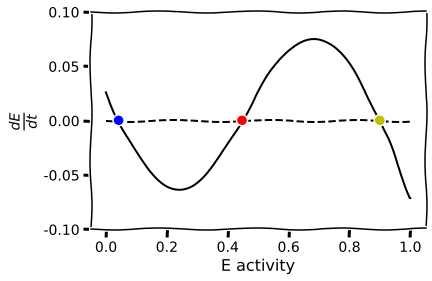

In [15]:
# to_remove solution
pars = default_parsE() # get default parameters

#set your external input and wEE
pars['I_ext_E'] = 0.5
pars['wEE'] = 5.0
 
# give E_grid
E_grid = np.linspace(0, 1., 1000)

# Calculate dEdt
dEdt = -E_grid + F(pars['wEE']*E_grid+pars['I_ext_E'], pars['a_E'],  pars['theta_E'])


with plt.xkcd():
  plot_dE_E(E_grid, dEdt)
  #Calculate the fixed point with your initial value
  
  x_fp_1 = my_fpE(pars, 0.)
  if check_fpE(pars, x_fp_1):
    plt.plot(x_fp_1, 0, 'bo', ms=8)

  x_fp_2 = my_fpE(pars, 0.4)
  if check_fpE(pars, x_fp_2):
    plt.plot(x_fp_2, 0, 'ro', ms=8)

  x_fp_3 = my_fpE(pars, 0.9)
  if check_fpE(pars, x_fp_3):
    plt.plot(x_fp_3, 0, 'yo', ms=8)

  plt.show()

#### Interactive Demo: fixed points as a function of recurrent and external inputs.

You can now explore how the previous plot changes when the recurrent coupling $w_{\text{EE}}$ and the external input $I_E^{\text{ext}}$ take different values.

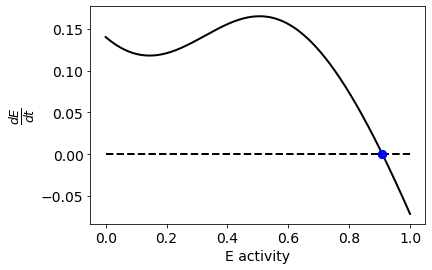

In [16]:
#@title Fixed point Explorer

def plot_intersection_E(wEE, I_ext_E):
  #set your parameters
  pars['wEE'] = wEE
  pars['I_ext_E'] = I_ext_E

  #note that wEE !=0
  if wEE>0:
    # find fixed point
    x_fp_1 = my_fpE(pars, 0.)
    x_fp_2 = my_fpE(pars, 0.4)
    x_fp_3 = my_fpE(pars, 0.9)

    plt.figure()
    E_grid = np.linspace(0, 1., 1000)
    dEdt = -E_grid + F(wEE*E_grid+I_ext_E, pars['a_E'],  pars['theta_E'])

    plt.plot(E_grid, dEdt, 'k')
    plt.plot(E_grid, 0.*E_grid, 'k--')
    
    if check_fpE(pars, x_fp_1):
        plt.plot(x_fp_1, 0, 'bo', ms=8)
    if check_fpE(pars, x_fp_2):
        plt.plot(x_fp_2, 0, 'bo', ms=8)
    if check_fpE(pars, x_fp_3):
        plt.plot(x_fp_3, 0, 'bo', ms=8)

    plt.xlabel('E activity', fontsize=14.)
    plt.ylabel(r'$\frac{dE}{dt}$', fontsize=18.)

    plt.show()

_ = widgets.interact(plot_intersection_E, wEE = (1., 7., 0.2), \
                                          I_ext_E = (0., 3., 0.1)) 

## Summary

In this tutorial, we have investigated the dynamics of a rate-based single excitatory population of neurons.

We learned about:
- The effect of the input parameters and the time constant of the network on the dynamics of the population.
- How to find the fixed point(s) of the system.

Next, we have two Bonus, but important concepts in dynamical system analysis and simulation. If you have time left, watch the next video and proceed to solve the exercises. You will learn:

- How to determine the stability of a fixed point by linearizing the system.
- How to add realistic inputs to our model.

## Bonus 1: Stability of a fixed point

Video available at https://youtube.com/watch?v=nvxxf59w2EA


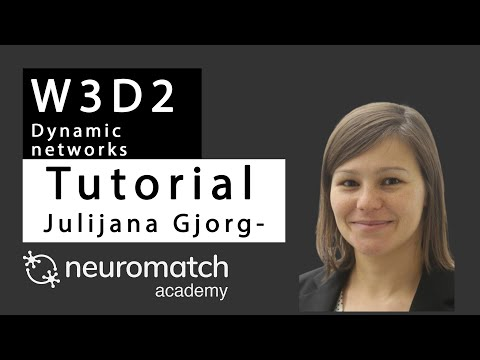

In [17]:
#@title Video: Stability of fixed points
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="nvxxf59w2EA", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

#### Initial values and trajectories

Here, let us first set $w_{EE}=5.0$ and $I^{\text{ext}}_E=0.5$, and investigate the dynamics of $E(t)$ starting with different initial values $E(0) \equiv E_{\text{init}}$. We will plot the trajectories of $E(t)$ with $E_{\text{init}} = 0.0, 0.1, 0.2,..., 0.9$.

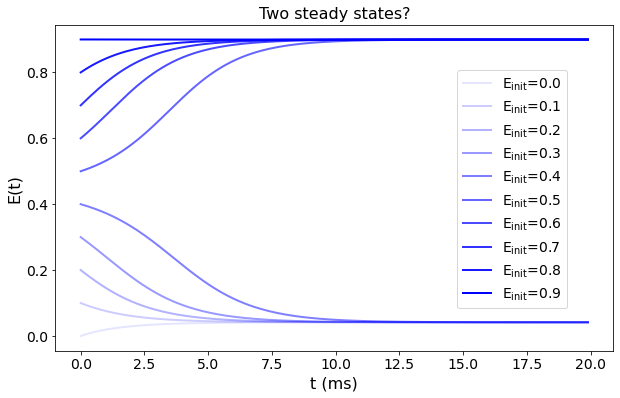

In [18]:
#@title Initial values
pars = default_parsE()
pars['wEE'] = 5.0
pars['I_ext_E'] = 0.5

plt.figure(figsize=(10,6))
for ie in range(10):          
  pars['E_init'] =  0.1*ie # set the initial value
  E = simulate_E(pars)   # run the simulation
  # plot the activity with given initial
  plt.plot(pars['range_t'], E, 'b', alpha=0.1 + 0.1*ie, label= r'E$_{\mathrm{init}}$=%.1f' % (0.1*ie))

plt.xlabel('t (ms)')
plt.title('Two steady states?')
plt.ylabel('E(t)')
plt.legend(loc=[0.72, 0.13], fontsize=14)
plt.show()


#### Interactive Demo: dynamics as a function of the initial value.


Let's now set $E_{init}$ to a value of your choice in this demo. How does the solution change? What do you observe?

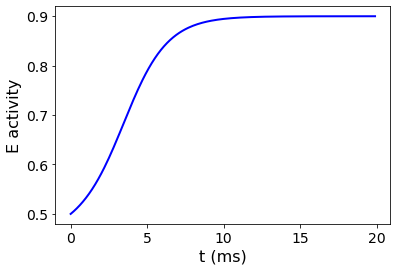

In [19]:
#@title Initial value Explorer
pars = default_parsE()
pars['wEE'] = 5.0
pars['I_ext_E'] = 0.5

def plot_E_diffEinit(E_init):
  pars['E_init'] =  E_init
  E = simulate_E(pars)
  
  plt.figure()
  plt.plot(pars['range_t'], E, 'b', label='E(t)')
  plt.xlabel('t (ms)', fontsize=16.)
  plt.ylabel('E activity', fontsize=16.)
  plt.show()

_ = widgets.interact(plot_E_diffEinit, E_init = (0., 1., 0.02)) 

### Stability analysis via linearization of the dynamics

Just like Equation $1$ in the case ($w_{EE}=0$) discussed above, a generic linear system 
$$\frac{dx}{dt} = \lambda (x - b),$$ 
has a fixed point for $x=b$. The analytical solution of such a system can be found to be:
$$x(t) = b + \big{(} x(0) - b \big{)} \text{e}^{\lambda t}.$$ 
Now consider a small perturbation of the activity around the fixed point: $x(0) = b+ \epsilon$, where $|\epsilon| \ll 1$. Will the perturbation $\epsilon(t)$ grow with time or will it decay to the fixed point? The evolution of the perturbation with time can be written, using the analytical solution for $x(t)$, as:
 $$\epsilon (t) = x(t) - b = \epsilon \text{e}^{\lambda t}$$

- if $\lambda < 0$, $\epsilon(t)$ decays to zero, $x(t)$ will still converge to $b$ and the fixed point is "**stable**".

- if $\lambda > 0$, $\epsilon(t)$ grows with time, $x(t)$ will leave the fixed point $b$ exponentially and the fixed point is, therefore, "**unstable**" .

### Compute the stability of Equation (1)

Similar to what we did in the linear system above, in order to determine the stability of a fixed point $E_{\rm fp}$ of the excitatory population dynamics, we perturb Equation $1$ around $E_{\rm fp}$ by $\epsilon$, i.e. $E = E_{\rm fp} + \epsilon$. We can plug in Equation $1$ and obtain the equation determining the time evolution of the perturbation $\epsilon(t)$:

\begin{align}
\tau_E \frac{d\epsilon}{dt} \approx -\epsilon + w_{EE} F'(w_{EE}E_{\text{fp}} + I^{\text{ext}}_E;a_E,\theta_E) \epsilon 
\end{align}
where $F'(\cdot)$ is the derivative of the transfer function $F(\cdot)$. We can rewrite the above equation as:
\begin{align}
\frac{d\epsilon}{dt} \approx \frac{\epsilon}{\tau_E }[-1 + w_{EE} F'(w_{EE}E_{\text{fp}} + I^{\text{ext}}_E;a_E,\theta_E)] 
\end{align}

That is, as in the linear system above, the value of $\lambda = [-1+ w_{EE}F'(w_{EE}E_{\text{fp}} + I^{\text{ext}}_E;a_E,\theta_E)]/\tau_E$ determines whether the perturbation will grow or decay to zero, i.e., $\lambda$ defines the stability of the fixed point. This value is called the **eigenvalue** of the dynamical system.

### Exercise 4: Compute $dF$ and Eigenvalue

The derivative of the sigmoid transfer function is:
\begin{align} 
\frac{dF}{dx} & = \frac{d}{dx} (1+\exp\{-a(x-\theta)\})^{-1}  \\
& = a\exp\{-a(x-\theta)\} (1+\exp\{-a(x-\theta)\})^{-2}. 
\end{align}

Let's now find the expression for the derivative $\displaystyle{\frac{dF}{dx}}$ in the following cell and plot it.

In [20]:
# Exercise 4

def dF(x,a,theta): 
    """
    Population activation function.

    Args:
      x     : the population input
      a     : the gain of the function
      theta : the threshold of the function
    
    Returns:
      dFdx  : the population activation response F(x) for input x
    """

    #####################################################################
    ## TODO for students: compute dFdx, then remove NotImplementedError #
    #####################################################################
    # dFdx = ...
    raise NotImplementedError("Student excercise: compute the deravitive of F(x)")

    return dFdx

pars = default_parsE() # get default parameters
x = np.arange(0,10,.1) # set the range of input

# Uncomment below lines after completing the dF function
# plot_dFdt(x,dF(x,pars['a_E'],pars['theta_E']))


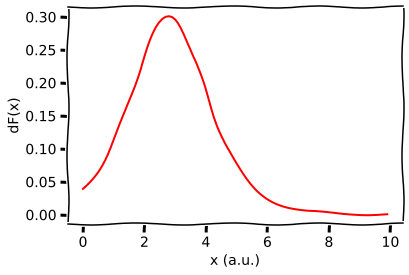

In [21]:
# to_remove solution
def dF(x,a,theta): 
  """
  Population activation function.

  Args:
    x     : the population input
    a     : the gain of the function
    theta : the threshold of the function
  
  Returns:
    dFdx  : the population activation response F(x) for input x
  """

  dFdx = a*np.exp(-a*(x-theta))*(1+np.exp(-a*(x-theta)))**-2

  return dFdx

# get default parameters
pars = default_parsE()

# set the range of input
x = np.arange(0,10,.1)

# plot figure
with plt.xkcd():
  plot_dFdt(x,dF(x,pars['a_E'],pars['theta_E']))



### Exercise 5: Compute eigenvalues 

As discussed above, for the case with $w_{EE}=5.0$ and $I^{\text{ext}}_E=0.5$, the system displays **3** fixed points. However, when we simulated the dynamics and varied the initial conditions $E_{\rm init}$, we could only obtain **two** steady states. In this exercise, we will now check the stability of each of the $3$ fixed points by calculating the corresponding eigenvalues with the function `eig_E` defined above. Check the sign of each eigenvalue (i.e., stability of each fixed point). How many of the fixed points are stable?

In [22]:
# Exercise 5
pars = default_parsE()
pars['wEE'] = 5.0
pars['I_ext_E'] = 0.5

def eig_E(pars, fp):
  """
  Args:
    pars : Parameter dictionary
    fp   : fixed point E
  
  Returns:
    eig : eigevalue of the linearized system
  """
  
  #get the parameters
  tau_E, a_E, theta_E = pars['tau_E'], pars['a_E'], pars['theta_E']
  wEE, I_ext_E = pars['wEE'],  pars['I_ext_E']
  # fixed point
  E = fp

  #######################################################################
  ## TODO for students: compute eigenvalue, remove NotImplementedError  #
  #######################################################################
  # eig = ...
  raise NotImplementedError("Student excercise: compute the eigenvalue")

  return eig

# Uncomment below lines after completing the eigE function.
# x_fp_1 = fpE(pars, 0.)
# eig_fp_1 = eig_E(pars, x_fp_1)
# print('Fixed point1=%.3f, Eigenvalue=%.3f' % (x_fp_1, eig_E1))

# Continue by finding the eigenvalues for all fixed points of Exercise 2

In [23]:
# to_remove solution
pars = default_parsE()
pars['wEE'] = 5.0
pars['I_ext_E'] = 0.5

def eig_E(pars, fp):
  """
  Args:
    pars : Parameter dictionary
    fp   : fixed point E
  
  Returns:
    eig : eigevalue of the linearized system
  """
  
  #get the parameters
  tau_E, a_E, theta_E = pars['tau_E'], pars['a_E'], pars['theta_E']
  wEE, I_ext_E = pars['wEE'],  pars['I_ext_E']
  # fixed point
  E = fp

  eig = (-1. + wEE*dF(wEE*E + I_ext_E, a_E, theta_E)) / tau_E 

  return eig

# Uncomment below lines after completing the eigE function
x_fp_1 = my_fpE(pars, 0.)
eig_E1 = eig_E(pars, x_fp_1)
print('Fixed point1=%.3f, Eigenvalue=%.3f' % (x_fp_1, eig_E1))

# Continue by finding the eigenvalues for all fixed points of Exercise 2
x_fp_2 = my_fpE(pars, 0.4)
eig_E2 = eig_E(pars, x_fp_2)
print('Fixed point2=%.3f, Eigenvalue=%.3f' % (x_fp_2, eig_E2))

x_fp_3 = my_fpE(pars, 0.9)
eig_E3 = eig_E(pars, x_fp_3)
print('Fixed point3=%.3f, Eigenvalue=%.3f' % (x_fp_3, eig_E3))

Fixed point1=0.042, Eigenvalue=-0.583
Fixed point2=0.447, Eigenvalue=0.498
Fixed point3=0.900, Eigenvalue=-0.626


### Think! 
Throughout the tutorial, we have assumed $w_{\rm EE}> 0 $, i.e., we considered a single population of **excitatory** neurons. What do you think will be the behavior of a population of inhibitory neurons, i.e., where $w_{\rm EE}> 0$ is replaced by $w_{\rm II}< 0$? 

## Bonus 2: Noisy input drives transition between two stable states



### Ornstein-Uhlenbeck (OU) process

As discussed in several previous tutorials, the OU process is usually used to generate a noisy input into the neuron. The OU input $\eta(t)$ follows: 

$$\tau_\eta \frac{d}{dt}\eta(t) = -\eta (t) + \sigma_\eta\sqrt{2\tau_\eta}\xi(t)$$

Execute the following function `my_OU(pars, sig, myseed=False)` to generate an OU process.

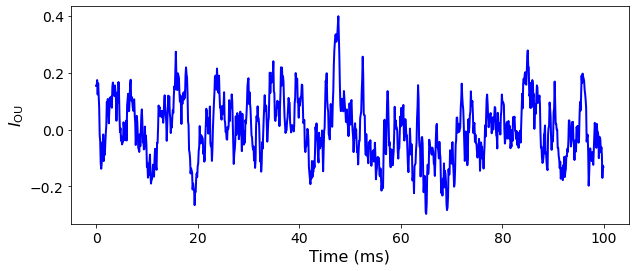

In [24]:
#@title OU process `my_OU(pars, sig, myseed=False)`
def my_OU(pars, sig, myseed=False):
  """
  A functions that generates Ornstein-Uhlenback process

  Args:
    pars       : parameter dictionary
    sig        : noise amplitute
    myseed     : random seed. int or boolean
  
  Returns:
    I          : Ornstein-Uhlenbeck input current
  """
  
  # Retrieve simulation parameters
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size
  tau_ou = pars['tau_ou'] # [ms]
  
  # set random seed
  if myseed:
      np.random.seed(seed=myseed) 
  else:
      np.random.seed()
      
  # Initialize
  noise =  np.random.randn(Lt)
  I = np.zeros(Lt)
  I[0] = noise[0] * sig
  
  #generate OU
  for it in range(Lt-1):
      I[it+1] = I[it] + dt/tau_ou*(0.-I[it]) + np.sqrt(2.*dt/tau_ou) * sig * noise[it+1]
  
  return I

pars = default_parsE(T=100)
pars['tau_ou'] = 1. #[ms]
sig_ou = 0.1
I_ou = my_OU(pars, sig=sig_ou, myseed=1998)
plt.figure(figsize=(10, 4))
plt.plot(pars['range_t'], I_ou, 'b')
plt.xlabel('Time (ms)')
plt.ylabel(r'$I_{\mathrm{OU}}$');

### Bonus Example: Up-Down transition

In the presence of two or more fixed points, noisy inputs can drive a transition between the fixed points! Here, we stimulate an E population for 1,000 ms applying OU inputs.

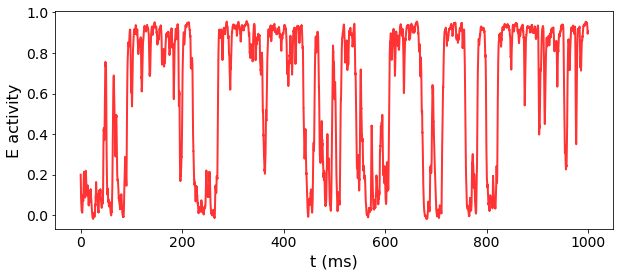

In [25]:
#@title Simulation of an E population with OU inputs
pars = default_parsE(T = 1000)
pars['wEE'] = 5.0
sig_ou = 0.7
pars['tau_ou'] = 1. #[ms]
pars['I_ext_E'] = 0.56 + my_OU(pars, sig=sig_ou, myseed=2020)

E = simulate_E(pars)

plt.figure(figsize=(10, 4))
plt.plot(pars['range_t'], E, 'r', alpha=0.8)
plt.xlabel('t (ms)')
plt.ylabel('E activity')
plt.show()